# Intro


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Data Analysis

We load the original dataset to check its structure and data types. We can see there are no missing/null values and no rows that are duplicated entirely.

In [95]:
dataset = pd.read_csv("dataset_2025.csv")

duplicates = dataset.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}\n")

dataset.info()
dataset.head()


Number of duplicate rows: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   name                150000 non-null  object 
 1   gender              150000 non-null  object 
 2   dob                 150000 non-null  object 
 3   postcode            150000 non-null  object 
 4   marital_status      150000 non-null  object 
 5   education           150000 non-null  object 
 6   employment          150000 non-null  object 
 7   num_children        150000 non-null  int64  
 8   home_ownership      150000 non-null  object 
 9   ethnicity           150000 non-null  object 
 10  income              150000 non-null  float64
 11  on_benefits         150000 non-null  bool   
 12  malnutrition_score  150000 non-null  float64
 13  disease             150000 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(10)
memory usa

,name,gender,dob,postcode,marital_status,education,employment,num_children,home_ownership,ethnicity,income,on_benefits,malnutrition_score,disease
0,James Taylor,male,24/10/1991,HX82 5XH,married,Bachelor,Student,6,Rent flat,English-Scottish,14484.06,False,37.86,heart failure
1,Robert Smith,male,13/07/2011,TN46 9DG,married,Bachelor,Retired,9,Rent house,Arab,26390.93,False,19.25,prostate cancer
2,Elizabeth Smith,female,21/07/1959,RH3 3FH,widowed,PhD/md,Unemployed,0,Rent room,Caribbean,21033.32,False,19.37,breast cancer
3,Linda Jones,female,24/09/2004,OX24 8NE,single,Masters,Retired,0,Rent room,Asian,30213.75,False,38.27,tuberculosis
4,David Taylor,male,26/09/2002,EH9 2YX,divorced,Less than High School,Employed,7,Rent room,other,42744.18,False,14.92,endometriosis


### Original Distrbution

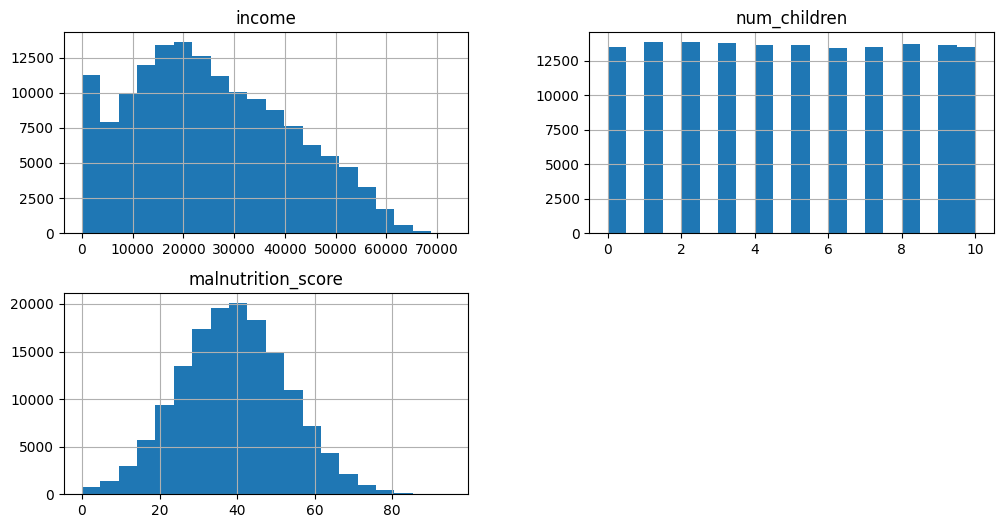

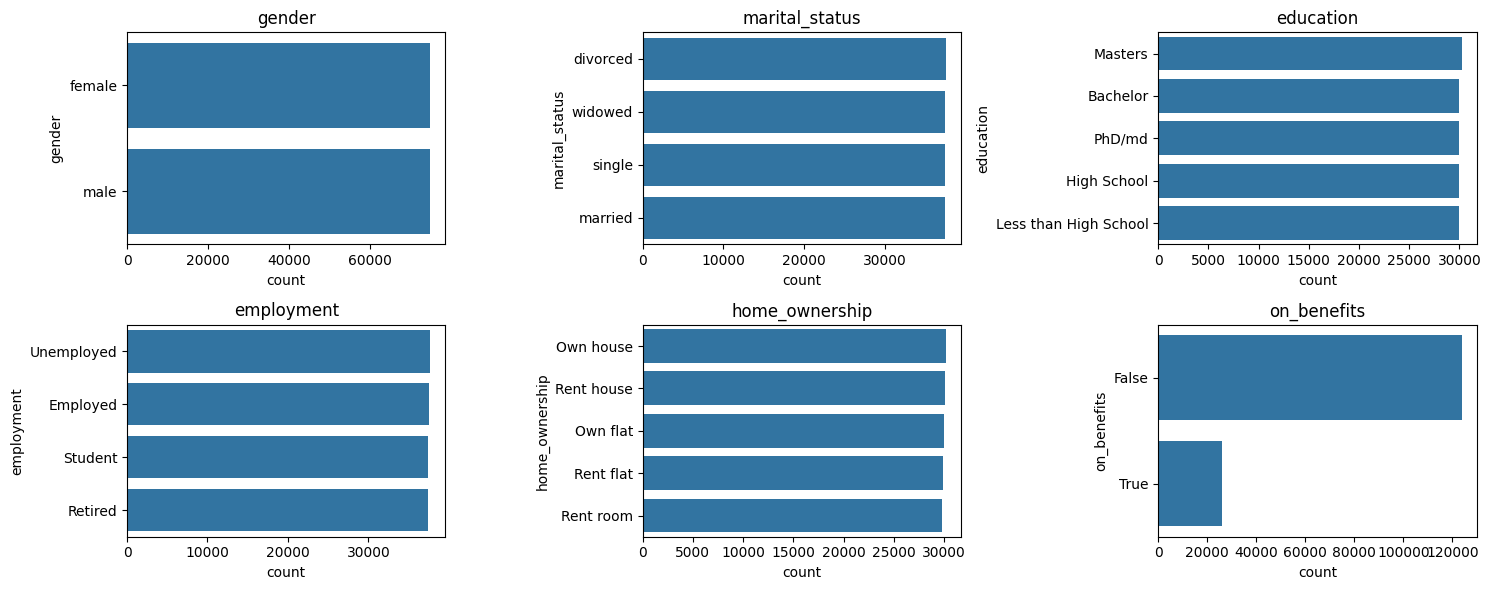

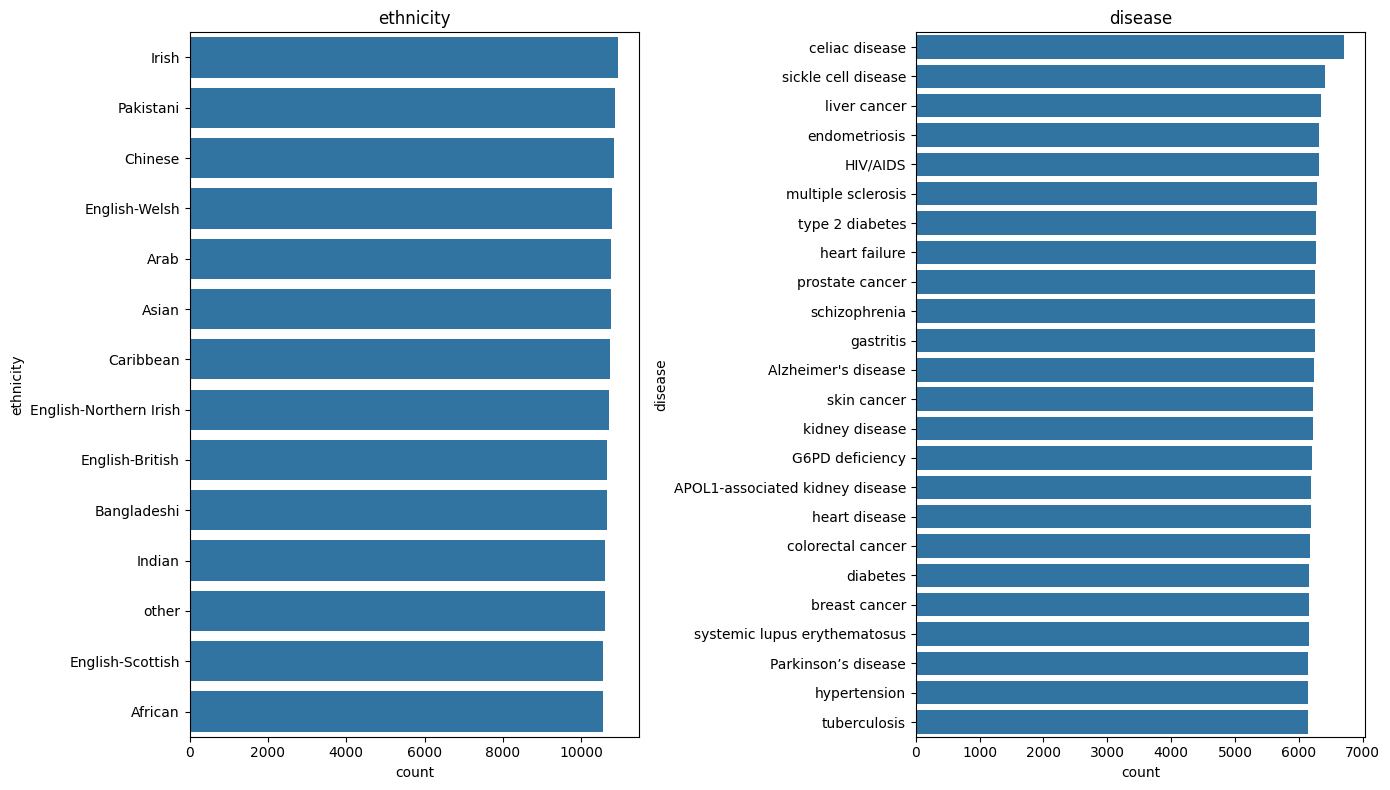

In [96]:
# numeric features
numeric_cols = ['income', 'num_children', 'malnutrition_score']
dataset[numeric_cols].hist(bins=20, figsize=(12,6))
plt.show()

# categorical features
categorical_cols_small = [
    'gender', 'marital_status', 'education', 'employment',
    'home_ownership', 'on_benefits'
]
categorical_cols_large = ['ethnicity', 'disease']

# small plots
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
for ax, col in zip(axes.flat, categorical_cols_small):
    sns.countplot(y=col, data=dataset, ax=ax, order=dataset[col].value_counts().index)
    ax.set_title(col)
plt.tight_layout()
plt.show()

# large plots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
for ax, col in zip(axes, categorical_cols_large):
    sns.countplot(y=col, data=dataset, ax=ax, order=dataset[col].value_counts().index)
    ax.set_title(col)
plt.tight_layout()
plt.show()

# Use Cases

Must retain utility for analysis → these attributes will not be overly generalized.


Use Case 1: Ethnicity ↔ Disease

- Key attributes: `ethnicity`, `disease`


Use Case 2: Fairness in on_benefits Decision

- Key attributes: `income`, `gender`, `ethnicity`, `dob`
- should preserve distribution to detect bias


Use Case 3: Geographic + Qualifications ↔ Malnutrition

- Key attributes: `postcode`, `education`, `malnutrition_score`


# Attribute Categories

Direct identifiers

- `name` is unique for each row, should be removed entirely and just use a pseudoID.

Quasi-identifiers

- `gender`, `dob`, `postcode`, `ethnicity`, `employment`, `income` → can be used to re-identify individuals when combined; should be generalized or perturbed (benchmarking on effect on utility).

- `marital_status` and `home_ownership` could also act as quasi-identifiers depending on context.

Sensitive attributes

- `disease`, `malnutrition_score`, `on_benefits` → must be protected from inference attacks.

Non-sensitive attributes

- `education`, `num_children` → can be kept as-is or slightly generalized (e.g., grouping).

# Hashing


# Generalizing attributes

### Benchmark functions for utility

Helper functions that can be called after generalizing attributes to check our methods have not changed distribution drastically and affected utility.

1. Aim for high KS similarity for numerical features: `income`, `malnutrition_score`, ...
2. Same for Chi2 on categorial features: `gender`, `education`, `ethnicity`, `disease`, ...
3. Use correlation to test relationships have been preserved: `ethnicity` <-> `disease`, `income` <-> `on_benefits`

In [97]:
from scipy.stats import ks_2samp, chi2_contingency, pearsonr

# KS test for similarity of numeric distributions
# Return: 1.0 (identical) to 0.0 (completely different)
def ks_similarity(original, transformed):
    stat, p = ks_2samp(original, transformed)
    return 1 - stat

# Chi-squared test for similarity of categorical proportions
def chi2_similarity(original, transformed):
    o_counts = original.value_counts(normalize=True)
    t_counts = transformed.value_counts(normalize=True)
    common = o_counts.index.intersection(t_counts.index)
    if len(common) < 2: 
        return 0
    contingency = np.array([o_counts[common], t_counts[common]])
    chi2, p, _, _ = chi2_contingency(contingency)
    return min(1, p)

# Test similarity of correlation between two columns c1 and c2
def corr_similarity(original, transformed, c1, c2):
    def encode(s): return pd.factorize(s)[0] if s.dtype == 'object' else s
    o_corr = pearsonr(encode(original[c1]), encode(original[c2]))[0]
    t_corr = pearsonr(encode(transformed[c1]), encode(transformed[c2]))[0]
    return 1 - abs(o_corr - t_corr)


In [98]:
def benchmark_usecase1(original, transformed):
    print("Use Case 1: Ethnicity <-> Disease\n==========")
    sim_eth = chi2_similarity(original['ethnicity'], transformed['ethnicity'])
    sim_dis = chi2_similarity(original['disease'], transformed['disease'])
    sim_corr = corr_similarity(original, transformed, 'ethnicity', 'disease')

    print(f"Ethnicity distribution similarity: {sim_eth:.3f}")
    print(f"Disease distribution similarity:   {sim_dis:.3f}")
    print(f"Ethnicity–Disease correlation similarity: {sim_corr:.3f}")

    utility_score = (sim_eth + sim_dis + sim_corr) / 3
    print(f"→ Overall utility score: {utility_score:.3f}")
    return utility_score


In [99]:
def benchmark_usecase2(original, transformed):
    print("Use Case 2: Fairness in on_benefits Decision\n==========")
    cols = ['income', 'gender', 'ethnicity', 'dob']
    sims = []

    # distribution similarity
    sims.append(ks_similarity(original['income'], transformed['income']))
    sims.append(chi2_similarity(original['gender'], transformed['gender']))
    sims.append(chi2_similarity(original['ethnicity'], transformed['ethnicity']))

    # correlations to on_benefits
    for c in ['income', 'gender', 'ethnicity']:
        sims.append(corr_similarity(original, transformed, c, 'on_benefits'))

    print(f"Distribution similarities: income={sims[0]:.3f}, gender={sims[1]:.3f}, ethnicity={sims[2]:.3f}")
    print(f"Correlation similarities: income↔on_benefits={sims[3]:.3f}, gender↔on_benefits={sims[4]:.3f}, ethnicity↔on_benefits={sims[5]:.3f}")

    utility_score = np.mean(sims)
    print(f"→ Overall utility score: {utility_score:.3f}")
    return utility_score

In [100]:
def benchmark_usecase3(original, transformed):
    print("Use Case 3: Geographic + Qualifications ↔ Malnutrition\n==========")
    sims = []

    # distribution similarities
    sims.append(chi2_similarity(original['postcode'], transformed['postcode']))
    sims.append(chi2_similarity(original['education'], transformed['education']))
    sims.append(ks_similarity(original['malnutrition_score'], transformed['malnutrition_score']))

    # correlation checks
    sims.append(corr_similarity(original, transformed, 'postcode', 'malnutrition_score'))
    sims.append(corr_similarity(original, transformed, 'education', 'malnutrition_score'))

    print(f"Distribution similarities: postcode={sims[0]:.3f}, education={sims[1]:.3f}, malnutrition={sims[2]:.3f}")
    print(f"Correlation similarities: postcode↔malnutrition={sims[3]:.3f}, education↔malnutrition={sims[4]:.3f}")

    utility_score = np.mean(sims)
    print(f"→ Overall utility score: {utility_score:.3f}")
    return utility_score


In [101]:
def benchmark_all(original, transformed):
    print("=== Benchmarking All Use Cases ===")
    score1 = benchmark_usecase1(original, transformed)
    print()
    score2 = benchmark_usecase2(original, transformed)
    print()
    score3 = benchmark_usecase3(original, transformed)
    print("==================================")
    overall_score = (score1 + score2 + score3) / 3
    print(f"Overall Utility Score across all use cases: {overall_score:.3f}")
    return overall_score

## Benchmark functions for privacy

In [ ]:
from scipy.stats import entropy

# higher entropy = more uncertainty/generalization = more privacy
def check_entropy(col):
    p = col.value_counts(normalize=True)
    p = p[p > 0]  # avoid log2(0)
    return -(p * np.log2(p)).sum()

# returns group size k for given quasi-identifiers
# i.e. each combination of quasi-identifiers appears at least k times
def k_anonymity(dataset, quasi_identifiers):
    group_sizes = dataset.groupby(quasi_identifiers).size()
    k = group_sizes.min()
    return k

# returns minimum number of distinct sensitive values in any equivalence class
def l_diversity(dataset, quasi_identifiers, sensitive_col):
    grouped = dataset.groupby(quasi_identifiers)[sensitive_col].nunique()
    l = grouped.min()
    return l

# returns maximum KL divergence between class and overall distribution
# Aim: check distribution of a sensitive attribute in each equivalence class is close to the overall distribution
def t_closeness(df, quasi_identifiers, sensitive_col):
    overall_dist = df[sensitive_col].value_counts(normalize=True)
    max_kl = 0
    for _, group in df.groupby(quasi_identifiers):
        group_dist = group[sensitive_col].value_counts(normalize=True)
        # Align indices
        all_idx = overall_dist.index.union(group_dist.index)
        p = overall_dist.reindex(all_idx, fill_value=0)
        q = group_dist.reindex(all_idx, fill_value=0)
        kl_div = entropy(q, p)  # KL divergence D_KL(Q || P)
        if kl_div > max_kl:
            max_kl = kl_div
    return max_kl



In [114]:
QUASI_IDS = [
    'gender', 'dob', 'postcode', 'ethnicity', 'employment', 'income'
]
SENSITIVE_ATTRS = ['disease', 'malnutrition_score', 'on_benefits']
# OPTIONAL_QUASI_IDS = ['marital_status', 'home_ownership']


# runs all the helper functions above to check privacy metrics
def check_privacy(dataset, quasi_identifiers=QUASI_IDS, sensitive_cols=SENSITIVE_ATTRS):
    report = {}
    
    # per column
    #report['entropy'] = {0}
    
    report['k_anonymity'] = k_anonymity(dataset, quasi_identifiers)
    
    # per sensitive column
    report['l_diversity'] = {col: l_diversity(dataset, quasi_identifiers, col) for col in sensitive_cols}
    #report['t_closeness'] = {col: t_closeness(dataset, quasi_identifiers, col) for col in sensitive_cols}
    
    print("=== Privacy Metrics ===")
    #print(f"Entropy per column:")
    #for col, e in report['entropy'].items():
    #    print(f"  {col}: {e:.3f}")
    print(f"k-anonymity (min group size): {report['k_anonymity']}")
    print(f"l-diversity per sensitive column:")
    for col, l in report['l_diversity'].items():
        print(f"  {col}: {l}")
    #print(f"t-closeness (max KL divergence) per sensitive column:")
    #for col, t in report['t_closeness'].items():
    #    print(f"  {col}: {t:.4f}")

    return report

### Dropping columns

Although `name` is not unique in this dataset (the least duplicated at 2924 entries), it is still information that could be used to identify someone and does not affect utility at all. Thus we drop it.

In [104]:
print(f"Number of unique names: {dataset['name'].nunique()}")
name_counts = dataset['name'].value_counts(ascending=True)
print(name_counts.head(2))

dataset.drop(columns=['name'], inplace=True)
print("\nDropped 'name' column.")

Number of unique names: 50
name
Robert Brown     2924
Barbara Jones    2924
Name: count, dtype: int64

Dropped 'name' column.


In [ ]:
#test run benchmark functions
benchmark_all(dataset, dataset)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 1.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 1.000
→ Overall utility score: 1.000

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=1.000, gender=1.000, ethnicity=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=1.000, ethnicity↔on_benefits=1.000
→ Overall utility score: 1.000

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=1.000, malnutrition=1.000
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=1.000
→ Overall utility score: 1.000
Overall Utility Score across all use cases: 1.000


np.float64(0.999999971146099)

In [115]:
check_privacy(dataset) # TODO: fix check_privacy function

Minimum l-diversity for disease: 1
Minimum l-diversity for malnutrition_score: 1
Minimum l-diversity for on_benefits: 1
=== Privacy Metrics ===
k-anonymity (min group size): 1
l-diversity per sensitive column:
  disease: 1
  malnutrition_score: 1
  on_benefits: 1


{'k_anonymity': np.int64(1),
 'l_diversity': {'disease': np.int64(1),
  'malnutrition_score': np.int64(1),
  'on_benefits': np.int64(1)}}